In [172]:
import numpy as np
import os

import geopandas as gpd
import pandas as pd
import pickle
import sklearn
import matplotlib.pyplot as plt
import urllib.request

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern, WhiteKernel

In [173]:
data_dir = '/home/simon/Documents/Bodies/data/OD_dataframes_compiled/'

with open(f'{data_dir}df_ucdp_prio.pkl', 'rb') as file:
    df = pickle.load(file)

In [175]:
print(f"{df['year'].min()},{df['year'].max()}")

1989,2019


In [180]:
12 * (df['year'].max() - df['year'].min())

360

In [181]:
df.groupby('gid').count()['month_id'].unique() # every gid should have 360 month ids....

array([372, 379, 378, 374, 404, 373, 377, 380, 376, 386, 409, 393, 382,
       375, 387, 403, 385, 390, 445])

# TEMP

In [4]:
test_gid = df.loc[df['log_best'] == df['log_best'].max(), 'gid'].values.item()
mask = df['gid'] == test_gid
df_test = df[mask].copy()
df_test.sort_values('month_id', inplace = True)

In [26]:

kernel_short = ConstantKernel() * Matern(length_scale=4.0, length_scale_bounds=(1, 10.0), nu=1.5)
kernel_long = ConstantKernel() * RBF(length_scale=20.0, length_scale_bounds=(10, 120))


kernel =  kernel_short + kernel_long

noise_std = df_test['log_best'].std()

gaussian_process = GaussianProcessRegressor(kernel=kernel, alpha=noise_std**2, n_restarts_optimizer=9)

In [52]:
y = np.array(df_test['log_best']).reshape(-1, 1)
x = np.array(df_test[['month_id']]).reshape(-1, 1)

In [33]:
gaussian_process.fit(x, y)
gaussian_process.kernel_

0.638**2 * Matern(length_scale=4.28, nu=1.5) + 0.286**2 * RBF(length_scale=59.3)

In [34]:
mean_prediction, std_prediction = gaussian_process.predict(x, return_std=True)

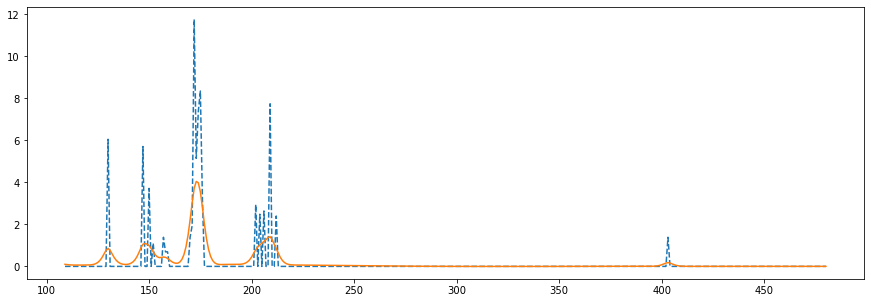

In [35]:
plt.figure(figsize =  [15,5])
plt.plot(x, y, '--', label="log best")
plt.plot(x, mean_prediction, label="Mean prediction")
plt.show()


## Multitaks

In [121]:
n_timelines = 6

test_gids = np.random.choice(df.loc[df['log_best'] > 4, 'gid'].unique(), n_timelines)
mask = df['gid'].isin(test_gids)
df_test2 = df[mask].copy()
df_test2.sort_values(['month_id', 'gid'], inplace = True) # this make reshape work

y = np.array(df_test2['log_best']).reshape(-1, n_timelines)
x = np.array(df_test2[['month_id']]).reshape(-1, n_timelines)



In [112]:
noise_std = y.std()

kernel_short = ConstantKernel() * Matern(length_scale=4.0, length_scale_bounds=(1, 10.0), nu=1.5)
kernel_long = ConstantKernel() * RBF(length_scale=20.0, length_scale_bounds=(10, 120))

kernel =  kernel_short + kernel_long + WhiteKernel(noise_level=noise_std)

# gaussian_process = GaussianProcessRegressor(kernel=kernel, alpha=noise_std**2, n_restarts_optimizer=9)
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

In [113]:
gaussian_process.fit(x, y)
gaussian_process.kernel_

0.276**2 * Matern(length_scale=5.43, nu=1.5) + 0.336**2 * RBF(length_scale=83.1) + WhiteKernel(noise_level=0.234)

In [114]:
mean_prediction, std_prediction = gaussian_process.predict(x, return_std=True)

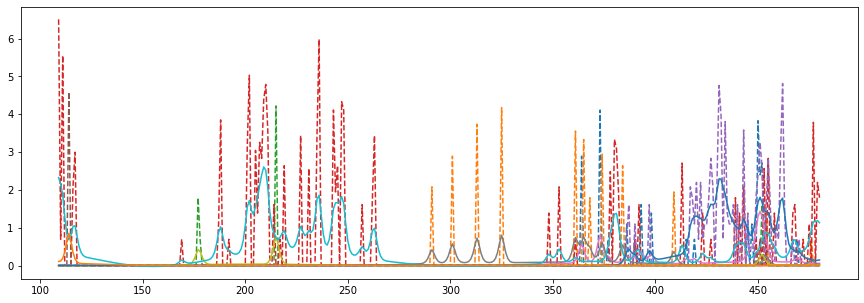

In [115]:
plt.figure(figsize =  [15,5])
plt.plot(x, y, '--', label="log best")
plt.plot(x, mean_prediction, label="Mean prediction")
plt.show()


## Only relevant geo

In [127]:
def get_cshapes():
    location = '/home/simon/Documents/Bodies/data/PRIO' 
    path_cshapes = location + "/CShapes-2.0.csv"
    
    if os.path.isfile(path_cshapes) == True:
        print('file already downloaded')
        cshapes = pd.read_csv(path_cshapes)


    else: 
        print('Beginning file download CShapes...')

        url_cshapes = 'https://icr.ethz.ch/data/cshapes/CShapes-2.0.csv'
    
        urllib.request.urlretrieve(url_cshapes, path_cshapes)
        cshapes = pd.read_csv(path_cshapes)

    return cshapes


In [128]:
cshapes = get_cshapes()
cshapes_mask = ['Gaza', 'West Bank', 'Jordan', 'Palestine', 'Israel', 'Iraq', 'Syria', 'Lebanon', 'Turkey (Ottoman Empire)']
gwno_to_keep = cshapes.loc[cshapes['cntry_name'].isin(cshapes_mask), 'gwcode'].unique()

file already downloaded


In [132]:
df_sub = df[df['gwno'].isin(gwno_to_keep)].copy()

In [157]:
test_gids = df_sub.loc[df_sub['log_best'] > 6, 'gid'].unique()
n_timelines = test_gids.shape[0]
print(n_timelines)
mask = df_sub['gid'].isin(test_gids)
df_test2 = df_sub[mask].copy()
df_test2.sort_values(['month_id', 'gid'], inplace = True) # this make reshape work

y = np.array(df_test2['log_best']).reshape(-1, n_timelines)
x = np.array(df_test2['month_id']).reshape(-1, n_timelines)

43


ValueError: cannot reshape array of size 16026 into shape (43)

In [167]:
df.groupby('gid').count()['month_id'].unique() #what the fuck.....

array([372, 379, 378, 374, 404, 373, 377, 380, 376, 386, 409, 393, 382,
       375, 387, 403, 385, 390, 445])

In [171]:
weird_gids = df.groupby('gid').count()[df.groupby('gid').count()['month_id'] !=372].index

In [164]:
df_sub.groupby('gid').count()['xcoord'].unique()

array([372, 382, 375, 379, 374, 373, 376, 377])

In [162]:
df_sub.groupby('gid').count()[df_sub.groupby('gid').count()['log_high'] != 372]  # why the fuck do you have missing and/or stuff here

,xcoord,ycoord,col,row,geometry,year,gwno,month,year_months_start,month_id,best,low,high,log_best,log_low,log_high
gid,,,,,,,,,,,,,,,,
174669,382,382,382,382,382,382,382,382,382,382,382,382,382,382,382,382
176832,375,375,375,375,375,375,375,375,375,375,375,375,375,375,375,375
177551,375,375,375,375,375,375,375,375,375,375,375,375,375,375,375,375
177552,379,379,379,379,379,379,379,379,379,379,379,379,379,379,379,379
177558,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374
178273,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374
178994,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374
179002,379,379,379,379,379,379,379,379,379,379,379,379,379,379,379,379
179713,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374,374


In [161]:
df_sub.groupby('gid').count()

,xcoord,ycoord,col,row,geometry,year,gwno,month,year_months_start,month_id,best,low,high,log_best,log_low,log_high
gid,,,,,,,,,,,,,,,,
171792,372,372,372,372,372,372,372,372,372,372,372,372,372,372,372,372
171810,372,372,372,372,372,372,372,372,372,372,372,372,372,372,372,372
171811,372,372,372,372,372,372,372,372,372,372,372,372,372,372,372,372
171812,372,372,372,372,372,372,372,372,372,372,372,372,372,372,372,372
171813,372,372,372,372,372,372,372,372,372,372,372,372,372,372,372,372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189793,372,372,372,372,372,372,372,372,372,372,372,372,372,372,372,372
190507,372,372,372,372,372,372,372,372,372,372,372,372,372,372,372,372
190508,372,372,372,372,372,372,372,372,372,372,372,372,372,372,372,372


In [142]:
test_gids.shape[0]

6

In [ ]:
n_timelines = 6

test_gids = np.random.choice(df.loc[df['log_best'] > 4, 'gid'].unique(), n_timelines)
mask = df['gid'].isin(test_gids)
df_test2 = df[mask].copy()
df_test2.sort_values(['month_id', 'gid'], inplace = True) # this make reshape work

y = np.array(df_test2['log_best']).reshape(-1, n_timelines)
x = np.array(df_test2[['month_id']]).reshape(-1, n_timelines)

In [129]:
gwno_to_keep

array([ 640,  645,  652,  660,  663,  665,  666, 6511, 6631])

# Spatial

In [44]:
np.array([y,y]).reshape(-1,2)

(372, 2)

In [ ]:
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.errorbar(
    X_train,
    y_train_noisy,
    noise_std,
    linestyle="None",
    color="tab:blue",
    marker=".",
    markersize=10,
    label="Observations",
)
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on a noisy dataset")

In [27]:
mean_prediction

array([ 2.90627260e-55, -9.09014511e-56,  2.84322567e-56, -8.89142478e-57,
        2.77627186e-57, -8.52973633e-58,  2.17596480e-58,  8.92346359e-59,
       -5.30798895e-58,  1.77382189e-57, -5.69515773e-57,  1.82155825e-56,
        7.29775615e-13, -2.28261854e-13,  7.13949299e-14, -2.23310953e-14,
        6.98474210e-15, -2.18468432e-15,  6.83328584e-16, -2.13732671e-16,
        6.68506989e-17, -2.09096965e-17,  6.54019285e-18, -2.04564082e-18,
        6.39832476e-19, -2.00128905e-19,  6.25959623e-20, -1.95788481e-20,
        6.12390242e-21, -1.91543041e-21,  5.99109792e-22, -1.87389528e-22,
        5.86116837e-23, -1.83327740e-23,  5.73409739e-24, -1.79352576e-24,
        3.31479594e-49, -1.03681052e-49,  3.24292134e-50, -1.01432391e-50,
        3.17262342e-51, -9.92325481e-52,  3.10383372e-52, -9.70814280e-53,
        3.03652080e-53, -9.49757587e-54,  2.97067334e-54, -9.29168368e-55,
       -1.12418201e-25,  3.59413706e-25, -1.14909897e-24,  3.67381359e-24,
       -1.17455961e-23,  

In [ ]:
mask = (df_sub.reset_index(level = 0)['gid'] == df_sub[df_sub['log_best'] == df_sub['log_best'].max()].reset_index(level = 0)['gid'].unique().item()).values
df_gp = df_sub[mask]

y = df_gp['log_best']
x = np.array(df_gp.reset_index(level = 1)['month_id']).reshape(-1, 1)

In [ ]:
gaussian_process.fit(x, y)
gaussian_process.kernel_

In [ ]:
mean_prediction, std_prediction = gaussian_process.predict(x, return_std=True)